# **Levenshtein distance as a Linguistic Distance Proxy**
*Written by Petter Stangeland*
____

The Levenshtein distance is a metric for measuring how different two strings are by counting the minimum number of single-character edits required to transform one string into the other. These edits are insertions, deletions, and substitutions.

$$
\text{lev}(a, b) = \begin{cases} |a| \qquad \qquad \qquad \qquad \qquad \qquad \ \ \ \  \text{if} \ |b| = 0, \\ 
|b| \qquad \qquad \qquad \qquad \qquad \qquad \ \ \ \  \text{if} \ |a| = 0, \\ 
\text{lev}(\text{tail}(a), \text{tail}(b)) \qquad \qquad \qquad \ \text{if} \ \text{head}(a) = \text{head}(b), 
\\ 1 + \text{min}\begin{cases}\text{lev}(\text{tail}(a), b)
\\ \text{lev}(a, \text{tail}(b)) \qquad \qquad \text{otherwise}
\\ \text{lev}(\text{tail}(a), \text{tail}(b)) 
\end{cases}\end{cases}
$$

where 
where the tail $\text{tail}(x)$ of some string $x$ is a string of all but the first character of $x$ (i.e. $\text{tail}(x_0x_1\dots x_n)=x_1x_2 \dots x_n$), and $\text{head}(x)$ is the first character of $x$ (i.e. $\text{head}(x_0x_1\dots x_n)=x_0$).

Originally developed by the Russian scientist Vladimir Levenshtein in 1965, this distance has become a fundamental concept in fields such as computational linguistics, natural language processing, and bioinformatics.


### *Example*
The three classical examples given to showcase how the Levenshtein distance measures distance is given by the pair "kitten" and "sitting with a Levenshtein distance of 3:

1. lev("kitten", "sitting"), d = 0
2. kitten → sitten (substitution of "s" for "k"), d = 1
3. sitten → sittin (substitution of "i" for "e"), d = 2
4. sittin → sitting (insertion of "g" at the end) d = 3

Thus, the result for lev("kitten", "sitting")=3.


### *Implementation*

There is a plethora of ways to implement the Levenshtein distance. Some of the most common ones are a recursive definition as described in the definition above, and an iterative way with using a matrix (also known as the Wagner–Fischer algorithm), and improved version of the interative method using only two matrix rows instead of the entire matrix. Each method improves upon the previous one in terms of either space or time complexity. Here, for simplicity, I have chosen to implement the iterative matrix method:

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from unidecode import unidecode
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
def levenshtein(a, b):
    m = len(a)
    n = len(b)
    
    matrix = [[0 for _ in range(n + 1)] for _ in range(m + 1)]
    
    for i in range(m + 1):
        matrix[i][0] = i
        
    for j in range(n + 1):
        matrix[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if a[i - 1] == b[j - 1]:
                matrix[i][j] = matrix[i - 1][j - 1]
            else:
                matrix[i][j] = 1 + min(matrix[i][j - 1], matrix[i - 1][j], matrix[i - 1][j - 1])
                
    return matrix[m][n]

Analysing the time and space complextiy we see the iterative matrix method uses both $\mathcal{O}(mn)$ time and space complexity.

Let's quickly confirm out example from earlier numerically:

In [15]:
a = "kitten"
b = "sitting"
d = levenshtein(a, b)
print(f'len("{a}", "{b}") = {d}')

len("kitten", "sitting") = 3


### *Application*
While you can use many the Levenshtein distance for many smart things such as word autocompletion and autocorrection as done in this article: [DitigalOcean: Implementing The Levenshtein Distance for Word Autocompletion and Autocorrection](https://www.digitalocean.com/community/tutorials/implementing-levenshtein-distance-word-autocomplete-autocorrect). However, I want to do something different. Instead, I want to apply the Levenshtein distance to look at linguistic (which I find more interesting). Namely, I want to use the Levenshtein distance as a proxy for the linguistic distance. According to Wikipedia, 

*the linguistic distance is the measure of how different one language (or dialect) is from another. Although they lack a uniform approach to quantifying linguistic distance between languages, linguists apply the concept to a variety of linguistic contexts, such as second-language acquisition, historical linguistics, language-based conflicts, and the effects of language differences on trade.*

It is exactly for this reason why I would like to use the Levenshtein distance as a, albeit crude, way to quantify the linguistic distance between languages.

### *Setup*

I will use the Levenshtein distance to compare 10 languages:

1. German

2. Norwegian

3. English

4. French

5. Spanish

6. Hindi

7. Urdu

8. Japanese

9. Cantonese

10. Mandarin

I began by selecting a list of the 100 most commonly used nouns in the English language. This list was then translated into various target languages, and I computed the Levenshtein distance between corresponding words in each pair of languages. The overall "distance" between two languages was defined as the sum of the Levenshtein distances across all 100 word pairs.

To enable consistent comparison across languages with different writing systems, such as Mandarin, Cantonese, Japanese, Hindi, and Urdu, I converted all text to widely recognized romanized forms, ensuring that every word was represented using the Latin alphabet. Additionally, to simplify tone and accent variation (e.g., tones marked in Mandarin Pinyin), I removed all diacritical marks, retaining only the base letters.


I chose these languages because they are among the most spoken in the world (yes, Norwegian included...). Additionally, based on their language families, we can form some a priori hypotheses about how similar or different they will be from one another.

Specifically, I expect the group of Western European languages German, Norwegian, English, French, and Spanish to be relatively similar to each other and quite different from the rest. Within this group, I anticipate French and Spanish to be especially close due to their shared Romance roots, German and Norwegian to be closely related as Germanic languages, and English to lie somewhere in between, sharing features with both Romance and Germanic languages.

I also expect Hindi and Urdu to form a distinct group. These two are often regarded as standardized registers of the same language, collectively known as Hindustani, and should therefore show a high degree of similarity.

Finally, I expect Mandarin, Cantonese, and Japanese to form another cluster. While Japanese is not genetically related to the Chinese languages, it has borrowed a significant amount of vocabulary from Classical Chinese, which may result in some similarities with Mandarin. However, I anticipate Mandarin and Cantonese to be much closer to each other than either is to Japanese.


First we combine all the different language .txt files into a single pandas Dataframe:

In [16]:
files_folder = "words"
files = [pd.read_csv(file, on_bad_lines='skip', header=None) for file in glob.glob(os.path.join(files_folder,"*txt"))]

column_names = ["german", "norwegian", "japanese", "hindi", "french", "urdu", "cantonese", "english", "mandarin", "spanish"]
df = pd.concat(files, axis=1, ignore_index=False)
df.columns = column_names
df["mandarin"] = df["mandarin"].apply(unidecode)
df["german"] = df["german"].apply(str.lower)
df["cantonese"] = df["cantonese"].apply(unidecode)
df["japanese"] = df["japanese"].apply(unidecode)
ordered = ["german", "norwegian", "english", "french", "spanish", "hindi", "urdu", "japanese", "cantonese", "mandarin"]
df = df.reindex(ordered, axis=1)
df.head()

,german,norwegian,english,french,spanish,hindi,urdu,japanese,cantonese,mandarin
0,zeit,tid,time,temps,tiempo,smy,waqt,jikan,sihgaan,shijian
1,jahr,år,year,année,año,vrs,saal,nen,nihn,nian
2,menschen,mennesker,people,personnes,gente,loga,log,hitobito,yahn,renmen
3,weg,vei,way,chemin,forma,raastaa,rasta,hoho,louh,fangshi
4,tag,dag,day,jour,día,din,din,hi,yaht,tian


Then we compute the total Levenshtein distance for all the language pairs:

In [17]:
result_df = pd.DataFrame(columns = df.columns, index = df.columns)
levenshtein_vec = np.vectorize(levenshtein)
for col1 in df:
    for col2 in df:
        result_df[col1][col2] = sum(levenshtein_vec(df[col1], df[col2]))


result_df

,german,norwegian,english,french,spanish,hindi,urdu,japanese,cantonese,mandarin
german,0,335,371,469,464,554,517,526,686,574
norwegian,335,0,340,439,437,529,487,490,682,561
english,371,340,0,361,366,517,460,466,665,550
french,469,439,361,0,379,573,536,535,718,603
spanish,464,437,366,379,0,540,504,500,687,562
hindi,554,529,517,573,540,0,392,531,665,563
urdu,517,487,460,536,504,392,0,510,656,564
japanese,526,490,466,535,500,531,510,0,645,513
cantonese,686,682,665,718,687,665,656,645,0,505
mandarin,574,561,550,603,562,563,564,513,505,0


### *Visualization*

Naturally, we see the distances are all symmetric and on the diagonal all equal 0. To get a better visual representation we convert it to a 2d numpy array and use matplotlib.pyplot's imshow to show the result:

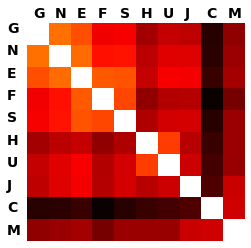

In [18]:
matrix = result_df.to_numpy(dtype=float)
chars = ["G", "N", "E", "F", "S", "H", "U", "J", "C", "M"]

def plot(chars, matrix):
    plt.imshow(matrix, cmap="hot_r")
    plt.axis("off")
    x1, y1 = 0.275, 0.90
    x2, y2 = 0.215, 0.85
    for char in chars:
        delta1 = 0.05
        delta2 = 0.078
        plt.text(x1, y1, char, weight='demibold', fontsize=14, transform=plt.gcf().transFigure)
        plt.text(x2, y2, char, weight='demibold', fontsize=14, transform=plt.gcf().transFigure)
        x1 += delta1
        y2 -= delta2
    
    plt.show()
plot(chars, matrix)

Here, the letters on the axes represent the first letter of each language. We can roughly see that the languages cluster into three groups as expected, but Japanese stands out as distinct from the others.

We could leave it at that, but I want to delve deeper by addressing an obvious issue I have so far overlooked. As mentioned earlier, Mandarin, Cantonese, Japanese, Hindi, and Urdu all use writing systems different from the Latin alphabet, and Mandarin and Cantonese are tonal languages. In my view, these factors should influence how we measure the linguistic distances.

To tackle this, I propose the following approach: from this point on, I interpret all distances from the perspective of an English speaker—that is, as a proxy for how difficult it would be for an English speaker to learn each language. Specifically, I multiply the distances for languages with non-Latin scripts by a script adjustment factor, $\sigma$, and for tonal languages by a tonal adjustment factor, $\tau$.

In order to estimate $\tau$ I used looked at the paper by (Wang et al., 1999) which showed that in test group of native speakers of American English had around a 69% accuracy in identifying the Chinese tones (commonly four tones), which I then used to estimate $\tau$ as $\tau = \frac{1}{0.7} \approx 1.43$.

In order to estimate $\sigma$ I looked at the Foreign Service Institues list of learning hours for different languages: In category 3 (~1000 hours) "Hard Languages" you find languages like Russian, Bengali, and Hebrew. In category 4 (~2000 hours) "Super-hard languages" you find languages like Japanese, Cantonese, and Mandarin. The average learning hours for category 1 and 2 is around 800 hours, giving multiplier 1.25 from category 1/2 to 3 and multiplier 2.5 for category 1/2 to 4. For simplicity I take $\sigma$ to be their average $\sigma \approx 1.875$.



### *Adjusting for tones and script*

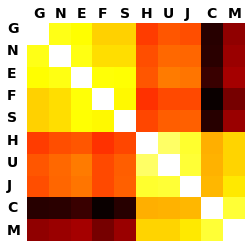

In [19]:
# Tonal adjusment
tau = 1.42 # tonal factor
N = len(chars)
P = np.eye(N)
P[-2:,-2:] *= tau
matrix = P@matrix@P
matrix[-2:,-2:] *= (1/tau)**2

#Script adjustment
sigma = 1.875
P = np.eye(N)
P[-5:,-5:] *= tau
matrix = P@matrix@P
matrix[-5:,-5:] *= (1/sigma)**2

plot(chars, matrix)

### *Conclusion*

In this notebook, I have implemented the iterative matrix method for computing the Levenshtein distance and applied it to explore linguistic distance between ten languages. By translating a set of common English nouns and computing pairwise Levenshtein distances between corresponding words, I constructed a basic quantitative measure of language similarity.

To account for structural differences in writing systems and the presence of tones, factors that are not captured by the Levenshtein distance alone, I introduced adjustment factors based on language learning difficulty and tone perception among native English speakers. While this approach relies on several heavy simplifications and assumptions, the resulting clusters of languages aligned broadly with known linguistic families and expected relationships. Further refinements, such as a less crude and more realistic way of incorporating phonetic, tonal and script information could enhance the accuracy and interpretability of the results. 

### *Sources*

* Wikipedia Contributors. (2019, June 11). Levenshtein distance. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/Levenshtein_distance Introduction to Levenshtein distance. (2023, July 16). 
* GeeksforGeeks. https://www.geeksforgeeks.org/introduction-to-levenshtein-distance/

* ‌Gad, A. F. (2020, March 15). Implementing The Levenshtein Distance for Word Autocompletion and Autocorrection. Digitalocean.com; DigitalOcean. https://www.digitalocean.com/community/tutorials/implementing-levenshtein-distance-word-autocomplete-autocorrect

* Wikipedia Contributors. (2023, July 16). Linguistic distance. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/Linguistic_distance

* Wang, Y., Spence, M. M., Jongman, A., & Sereno, J. A. (1999). Training American listeners to perceive Mandarin tones. The Journal of the Acoustical Society of America, 106(6), 3649–3658. https://doi.org/10.1121/1.428217

